In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

load_dotenv()

True

In [2]:

model = ChatGroq(
    model="llama-3.1-8b-instant"
)

In [3]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedbackfor the essay')
    score: int = Field(description='Score out of 10', ge=0, le=10)

In [4]:
structured_model = model.with_structured_output(EvaluationSchema)

In [5]:
essay = """'**The Rise of Artificial Intelligence: A Double-Edged Sword**\n\nArtificial Intelligence (AI) has revolutionized the way we live, work, and interact with each other. From virtual assistants like Siri and Alexa to self-driving cars and intelligent personal assistants, AI has become an integral part of our daily lives. However, the rapid advancement of AI has also raised concerns about its potential impact on society, economy, and individual freedoms. In this essay, we will explore the benefits and drawbacks of AI, its applications, and the challenges it poses to humanity.\n\n**The Benefits of AI**\n\nAI has numerous benefits that have improved the quality of life for millions of people worldwide. One of the most significant advantages of AI is its ability to automate repetitive and mundane tasks, freeing up human resources to focus on more complex and creative tasks. For instance, AI-powered chatbots have reduced the workload of customer service representatives, allowing them to focus on more complex issues and provide better customer experiences. AI has also improved the accuracy and efficiency of healthcare services, enabling medical professionals to diagnose diseases more accurately and develop personalized treatment plans.\n\nAnother significant benefit of AI is its ability to analyze vast amounts of data, providing insights that can inform business decisions and drive innovation. For example, AI-powered data analytics has helped companies like Walmart and Amazon optimize their supply chains, reducing costs and improving customer satisfaction. AI has also transformed the field of education, enabling personalized learning experiences and improving student outcomes.\n\n**The Drawbacks of AI**\n\nWhile AI has numerous benefits, it also poses significant risks to society, economy, and individual freedoms. One of the most significant concerns is the potential loss of jobs due to automation. As AI takes over routine and repetitive tasks, many workers may find themselves replaced by machines, leading to unemployment and economic instability. For instance, the rise of self-driving cars may lead to the loss of millions of jobs in the transportation sector.\n\nAnother significant concern is the potential for AI to perpetuate biases and prejudices. AI systems are trained on vast amounts of data, which can reflect existing societal biases and prejudices. For example, AI-powered facial recognition systems have been shown to be less accurate for people of color, highlighting the need for more inclusive and diverse training data.\n\n**The Applications of AI**\n\nAI has numerous applications across various industries, including healthcare, finance, transportation, and education. In healthcare, AI is being used to develop personalized treatment plans, improve disease diagnosis, and reduce medical errors. In finance, AI is being used to detect and prevent financial crimes, such as money laundering and terrorist financing.\n\nIn transportation, AI is being used to develop self-driving cars and improve traffic management systems. In education, AI is being used to develop personalized learning experiences, improve student outcomes, and reduce teacher workload. AI is also being used in the field of entertainment, creating more realistic and immersive experiences for consumers.\n\n**Challenges and Future Directions**\n\nAs AI continues to advance, it poses significant challenges to humanity. One of the most significant challenges is ensuring that AI is developed and used in a way that benefits society as a whole. This requires a multidisciplinary approach, involving experts from various fields, including computer science, philosophy, ethics, and sociology.\n\nAnother significant challenge is ensuring that AI is transparent, explainable, and accountable. As AI becomes more complex and autonomous, it is essential that we can understand how it makes decisions and take responsibility for its actions.\n\nIn conclusion, AI is a double-edged sword that has the potential to revolutionize our lives, but also poses significant risks to society, economy, and individual freedoms. While AI has numerous benefits, including improved efficiency, accuracy, and decision-making, it also has drawbacks, including the potential loss of jobs, perpetuation of biases, and lack of transparency and accountability.\n\nAs AI continues to advance, it is essential that we address these challenges and develop more inclusive, transparent, and responsible AI systems. This requires a collaborative effort from governments, industries, and individuals to ensure that AI is developed and used in a way that benefits humanity as a whole.'"""

In [6]:
prompt = f'Evalute the language quality of the essay and provide a feedback and assign a score out of 10 \n {essay}'

In [7]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [23]:
def evaluate_language(state: UPSCState):

    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [22]:
def evaluate_analysis(state: UPSCState):

    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [21]:
def evaluate_thought(state: UPSCState):

    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [20]:
def final_evaluation(state: UPSCState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculate
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [16]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

# edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

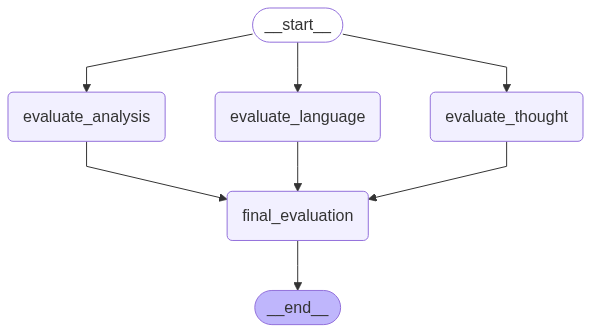

In [17]:
workflow

In [18]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [19]:
# Execute the workflow 

intial_state = {
    'essay': essay2
}

workflow.invoke(intial_state)

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: parameters for tool EvaluationSchema did not match schema: errors: [missing properties: 'score']", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=EvaluationSchema> {"feedback": "The essay is well-structured and showcases a good understanding of AI and its potential impact on India. However, the writing style is simple and lacks sophistication. The essay could benefit from more in-depth analysis and supporting evidence. Score: 6"} </function>'}}